In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.ticker import ScalarFormatter

In [2]:
#Moses saturation vapor pressure for T between 67 and 90.65K
T = 45
log10satp = 4.425070 - (453.92414/T) - (4055.6016/(T**2)) + (115352.19/(T**3)) - (1165560.7/(T**4))
satp = 10**log10satp #in atmospheres
saturatedvp = satp * 101325 
print(saturatedvp, "pascals") #in pascals

0.02101092463983677 pascals


In [5]:
#Lavvas saturation vapor pressure for T between 48 and 90.6K s-g
A = 6.31972
B = 451.64
C = -4.66
log10satp_L = A - (B/(T+C))
satp = 10**log10satp_L #in kPa
Lavvas_satp = satp * 1000 #in Pa
print(Lavvas_satp, "pascals")

0.01330100941563863 pascals


In [6]:
#Moses density in kg m^-3
#density of the condensed phase = rho in Lavvas
rho = 511.712 + (0.180922*T) - ((1.158657e-2)*(T**2)) + ((2.5157e-5)*(T**3))
print(rho, "kg/m^3")

498.683117375 kg/m^3


In [7]:
rr = np.linspace(-2, 2, num=200)
r = 10**rr
#print("r =", r)

s_original = np.linspace(-7,np.log10(0.4),num = 200)

s = 10**s_original
#print("s =", s)

In [8]:
Lsub = 10 #kJ/mol
Lvap = 8.5 #kJ/mol
sigma0 = 16.984
T_crit = 190.6
T0 = 90.95
Ttriple = 90.69
sigma_lg = (sigma0/1000) * ((T_crit - Ttriple)/(T_crit - T0))**(11/9) #in kg/s^2
print("sigma l-g =", sigma_lg)
sigma_sg = sigma_lg * (Lsub/Lvap)**2 #J/m^2
print("sigma s-g =", sigma_sg)

meshedr, mesheds = np.meshgrid(r,s) #Z will be a function of r (radius) and s (supersaturation)
#print("meshedr =", meshedr)
#print("mesheds =", mesheds)
#print(len(meshedr))
meshedr2 = meshedr/(10**6)

meshedS = mesheds + 1 #meshed saturation S
#print("S2 =", S2)
#print(len(S2))

M = 0.01604 #kg/mol
R = 8.3145 #J/mol*K
a_g = (2*M*sigma_sg)/(R*T*rho*np.log(meshedS)) #in meters
#print("a_g =", a_g)
#print(len(a_g))

pp = Lavvas_satp * meshedS #meshed partial pressures
#print(len(pp))
#print("partial pressures in pascals =", pp)

sigma l-g = 0.01703817663191188
sigma s-g = 0.02358225139364966


In [9]:
k = 1.3806e-23 #J/K or m^2*kg/s^2*K
m = 0.01604/(6.022e23) #in kg
flux = (pp/(np.sqrt(2*T*m*k*math.pi))) #in #/m^2*s
#print("flux =", flux)

v = 1e-13 #oscillation frequency in Hz (#/sec)
Gdes = 0.18 * (1.602e-19) #desorption energy in J (1 eV = 1.602e-19 J)
c = (flux/v) * np.exp(Gdes/(k*T)) #in #/m^2

Fg = (4*math.pi*(a_g**2)*sigma_sg)/3 #in J

mu = 0.995 #unitless
x = meshedr2/a_g #unitless
phi = (1 - (2*mu*x) + (x**2))**(1/2)
f0 = (x - mu) / phi
f = (1/2)*(1+(((1-(mu*x))/phi)**3)+((x**3)*(2-(3*f0)+(f0**3)))+((3*mu*(x**2))*(f0-1))) #unitless
Fgs = Fg * f #in J

g = (4/3)*math.pi*(a_g**3)*rho*(6.022e23/M) #unitless, already meshed bc a_g is meshed already
z = (Fgs/(3*math.pi*k*T*(g**2)))**(1/2) #unitless (dimensionless Z factor)

J = np.log10(4*np.pi*(meshedr2**2)*(a_g**2)*flux*c*z*np.exp(-Fgs/(k*T))) #in #/second, and this is log base 10 of J

/usr/local/anaconda3-2018/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in sqrt
/usr/local/anaconda3-2018/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10


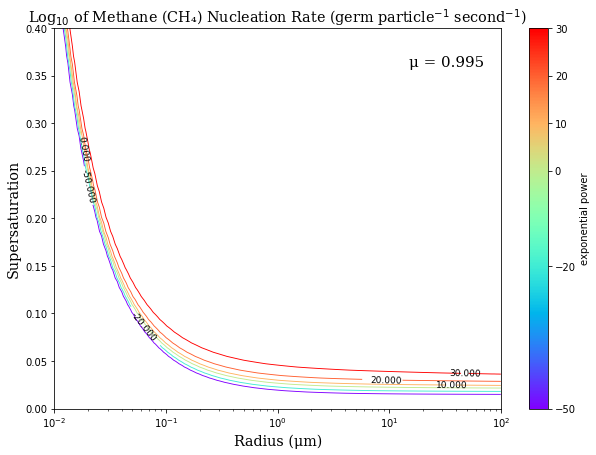

In [10]:
import matplotlib.mlab as mlab
import matplotlib.colors

plt.figure(figsize=(10,7))
levels = [-50,-20,0,10,20,30]

cs = plt.contour(meshedr, mesheds, J, levels, linestyles='solid', linewidths = 0.9, cmap = 'rainbow')
norm= matplotlib.colors.Normalize(vmin=cs.cvalues.min(), vmax=cs.cvalues.max())
sm = plt.cm.ScalarMappable(norm=norm, cmap = cs.cmap)
sm.set_array([])
cbar = plt.colorbar(sm, ticks=cs.levels)
cbar.set_label('exponential power')

plt.clabel(cs, inline = True, inline_spacing = 0.4, fontsize = 9, colors = 'black', use_clabeltext = True)
plt.xlabel("Radius (\u03BCm)",fontfamily='serif',fontsize='x-large')
plt.xscale("log")
plt.ylabel("Supersaturation",fontfamily='serif',fontsize='x-large')
plt.title("Log$_{10}$ of Methane (CH\u2084) Nucleation Rate (germ particle$^{-1}$ second$^{-1}$)",fontfamily='serif',fontsize='x-large')
plt.text(x=15,y=0.36,s="\u03BC = 0.995",fontsize=15,fontfamily='serif')
plt.savefig(fname='Methane supersat vs r.png', dpi=300)